In [647]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir, flat=True)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

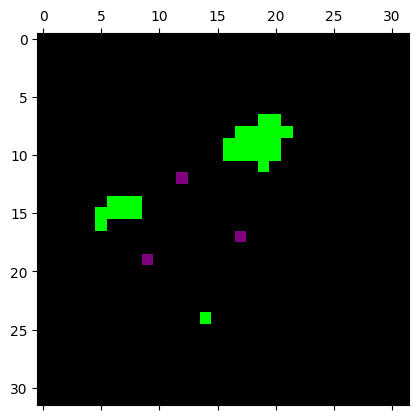

In [651]:
# displays test env large 6
test_envs["small_3-2"].display(chs=["map"])

In [616]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

def diffuse(r,l, cutoff=0.5):
    l = l>0 # convert to boolean in case it isn't

    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
    ksum = np.sum(kernel)

    # cutoff = np.random.random(r.shape)*0.25+0.3
    free_cells = (r < cutoff) * l # free cells are those that are not full 
    # sources are those that are full and have at least one free neighbor
    sources = (r >= cutoff) * l

    # How large of an area could a cell's resevoir flow to
    flow_area = convolve(free_cells, kernel) * l
    flow_area[l] += 1 # every cell includes itself

    # Nonzero just avoids divide by zero, this is just 5/flow_area * r, which is the adjusted nutrients 
    # to "bounce back" diffusion off of full cells and voids
    to_diff = np.divide(ksum, flow_area, out=np.zeros_like(r), where=flow_area!=0) * r

    kernel[1,1] = 1
    kernel *= (1./ksum)
    sinks = convolve(to_diff, kernel) * free_cells # sinks serve as sources to other sinks too


    # creates an array where free_cells have the value of sinks and sources have the value of to_diff * 0.2
    diffused = np.zeros_like(r)
    diffused[free_cells] = sinks[free_cells]
    diffused[sources] = to_diff[sources] * (1./ksum)
    return diffused

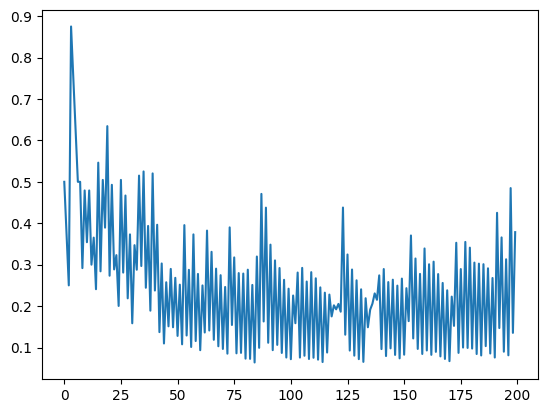

In [685]:
max_food = 10
cutoff = 0.5
food_rate = 0.5
tenv = PetriDish.from_env("tenv", test_envs["small_4-3"])

tenv.resv += tenv.fd()*max_food
tenv.resv += tenv.life

diffs = []
# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=33) as vid:

    for i in range(200):
        # if i<0:
        tenv.resv += tenv.fd()*food_rate
        
        presv = tenv.resv
        tenv.resv = diffuse(tenv.resv, tenv.life, cutoff=cutoff)

        diffs.append((tenv.resv * tenv.sk()*0.25).sum())
        tenv.resv -= tenv.sk()*0.25 # removes nutrients from sinks
        # tenv.resv -= lined_grid * 1 * tenv.resv
        tenv.resv = np.clip(tenv.resv, 0, max_food)

        if i % 1 == 0:
            tenv.resv[0,0] = max_food
            tenv.resv[0,1] = 0
            vid.add_concat_grids([tenv.resv], cmaps=["viridis"], cols = 1)
diffs = np.array(diffs)
# plots diffs
plt.plot(diffs)

In [169]:
von_n = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
von_nc = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.float32)
von_avg = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]], dtype=np.float32)

In [405]:
grid_size = 32
# Indexes of 2d chunks spacing

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

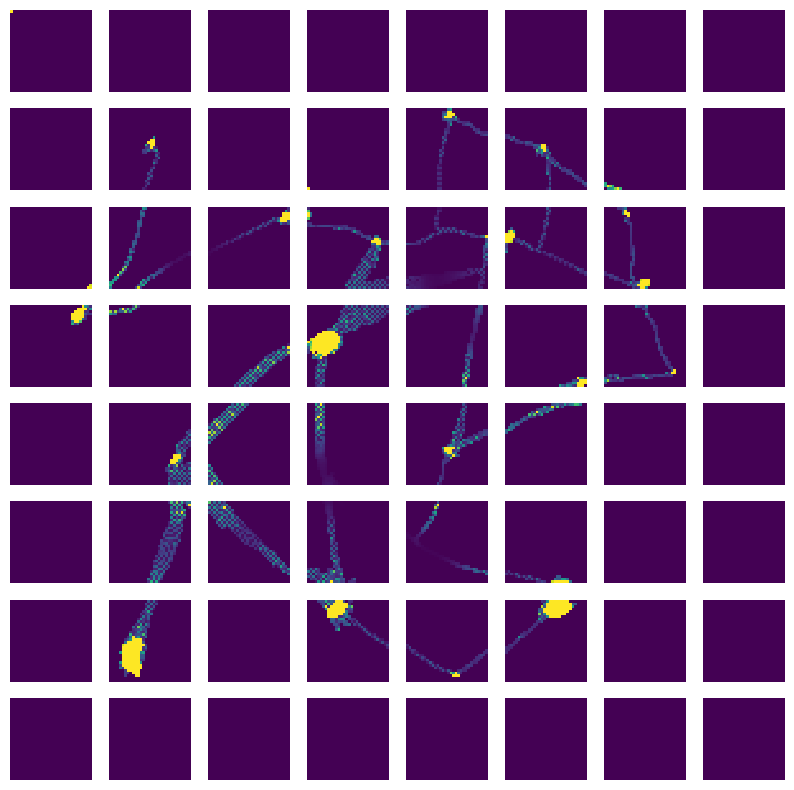

In [399]:
spacing = 32
# fetches spacing by spacing tiles from the resevoir
tiles = np.array([tenv.resv[i:i+spacing, j:j+spacing] for i in range(0, tenv.width, spacing) for j in range(0, tenv.width, spacing)])

# displays all tiles in a large grid figure
fig, axs = plt.subplots(math.ceil(tenv.width/spacing), math.ceil(tenv.width/spacing), figsize=(10,10))
for i in range(math.ceil(tenv.width/spacing)):
    for j in range(math.ceil(tenv.width/spacing)):
        axs[i,j].matshow(tiles[i*int(math.ceil(tenv.width/spacing))+j], cmap="viridis")
        axs[i,j].axis("off")
plt.show()
# for i in range(len(tiles)):

#     plt.subplot(4,4,i+1)
#     plt.imshow(tiles[i], cmap="viridis")
#     plt.colorbar()
#     plt.title(f"Tile {i}")

In [389]:
# plt.matshow(tenv.resv)

w = tenv.width
cutw = spacing*(w//spacing)
src = tenv.resv[:cutw,:cutw]
src = src.reshape((spacing, spacing, (w//spacing)*(w//spacing)))

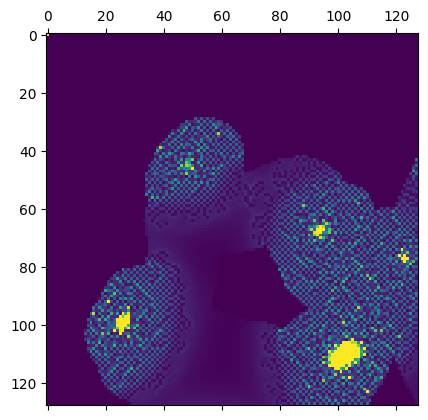

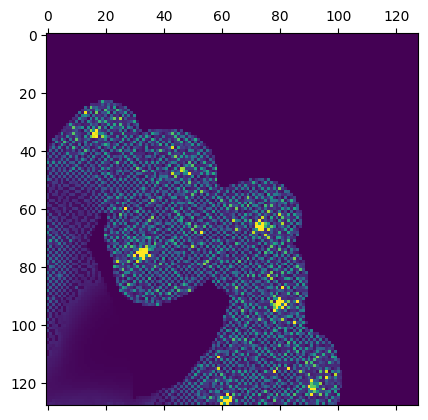

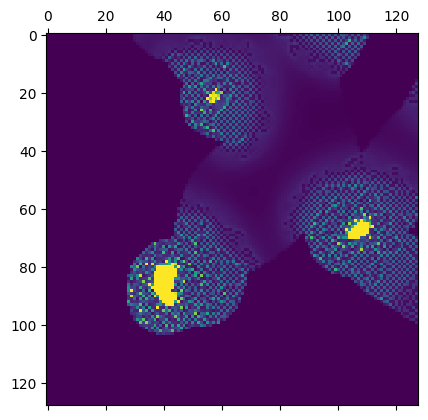

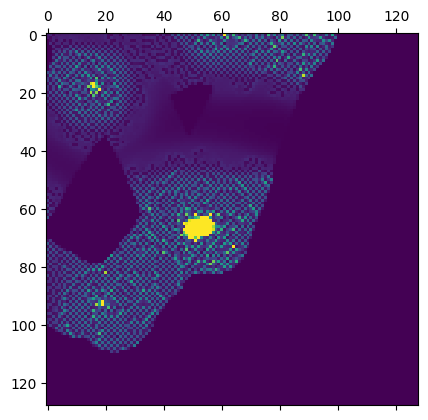

In [ ]:

# displays r and l with colorbars shrunk to 0.45
# fig, axs = plt.subplots(1,2, figsize=(10,10))
# fig.colorbar(axs[0].matshow(r), ax=axs[0], shrink=0.35)
# fig.colorbar(axs[1].matshow(l), ax=axs[1], shrink=0.35)

# diffuses r and l 100 times and makes a video  
with VideoWriter(filename="./encasm/results/diffusion.mp4", fps=2) as vw:
    for i in range(100):
        # r = diffuse(r,l, cutoff = 0.3)
        # # adds nutrients to the resevoir of the middle
        r[w//2,w//2] += 0.1

        neigh_sum = convolve(r, von_nc)
        neigh_size = convolve(l, von_nc)

        r = np.where(neigh_size>0, r, neigh_sum/neigh_size)


        r[0,0] = 1
        vw.add_concat_grids([r], cols=1)



In [194]:
# 2d array example
a = np.array([[1,2,3],[4,5,0],[7,8,9]])
np.where(a!=0, 1/a, a)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/310576515.py:3: RuntimeWarning: divide by zero encountered in divide
  np.where(a!=0, 1/a, a)


array([[1.        , 0.5       , 0.33333333],
       [0.25      , 0.2       , 0.        ],
       [0.14285714, 0.125     , 0.11111111]])

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/231250835.py:27: RuntimeWarning: invalid value encountered in divide
  fig.colorbar(axs[2].matshow(np.where(neigh_size>0, neigh_sum/neigh_size, 0)), ax=axs[2], shrink=0.35)
/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/231250835.py:30: RuntimeWarning: invalid value encountered in divide
  print(np.where(neigh_size>0, neigh_sum/neigh_size, 0).sum())


3.0
3.15


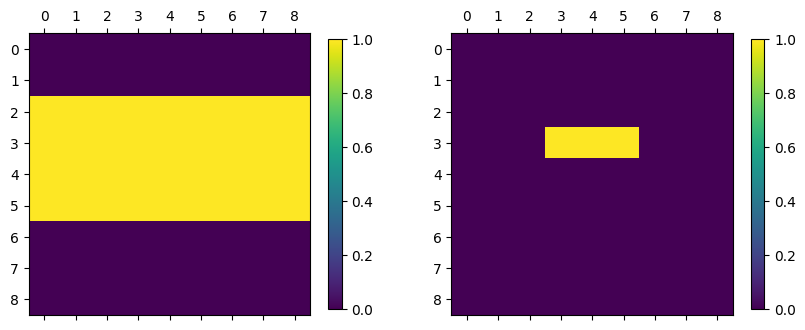

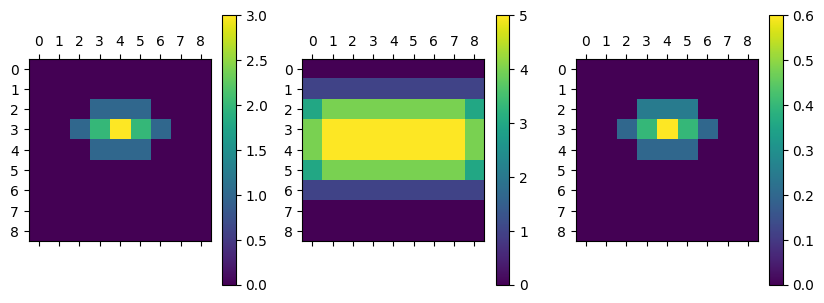

In [211]:
w = 9
# r and l are both wxw arrays
r = np.zeros((w,w), dtype=np.float32)
l = np.zeros((w,w), dtype=np.float32)

# r contains a horizontal stripe 1 wide and 3 long of nutrients in the center
r[w//2-1:w//2, w//2-1:w//2+2] = 1
# r[w//2:w//2+1,:] = 1
l[w//2-2:w//2+2,:] = 1


# l contains a horizontal stripe of life 3 wide and w long in the center

# displays r,l, and neigh arrays and their ratio accounting for 0s in the denominator 
fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.colorbar(axs[0].matshow(l), ax=axs[0], shrink=0.35)
fig.colorbar(axs[1].matshow(r), ax=axs[1], shrink=0.35)


neigh_sum = convolve(r, von_nc)
neigh_size = convolve(l, von_nc)


fig, axs = plt.subplots(1,3, figsize=(10,10))
fig.colorbar(axs[0].matshow(neigh_sum), ax=axs[0], shrink=0.35)
fig.colorbar(axs[1].matshow(neigh_size), ax=axs[1], shrink=0.35)
fig.colorbar(axs[2].matshow(np.where(neigh_size>0, neigh_sum/neigh_size, 0)), ax=axs[2], shrink=0.35)

print(r.sum())
print(np.where(neigh_size>0, neigh_sum/neigh_size, 0).sum())
# shows the functionality of np.where to use a mask to set items in a
# np.where(neigh_size>0, r, neigh_sum/neigh_size)
# neigh_sum, neigh_size, np.where(neigh_size>0, neigh_sum/neigh_size, 0)

In [274]:
tenv.life = np.ones_like(tenv.life)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/3478897244.py:7: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)>0), cmap="hot")


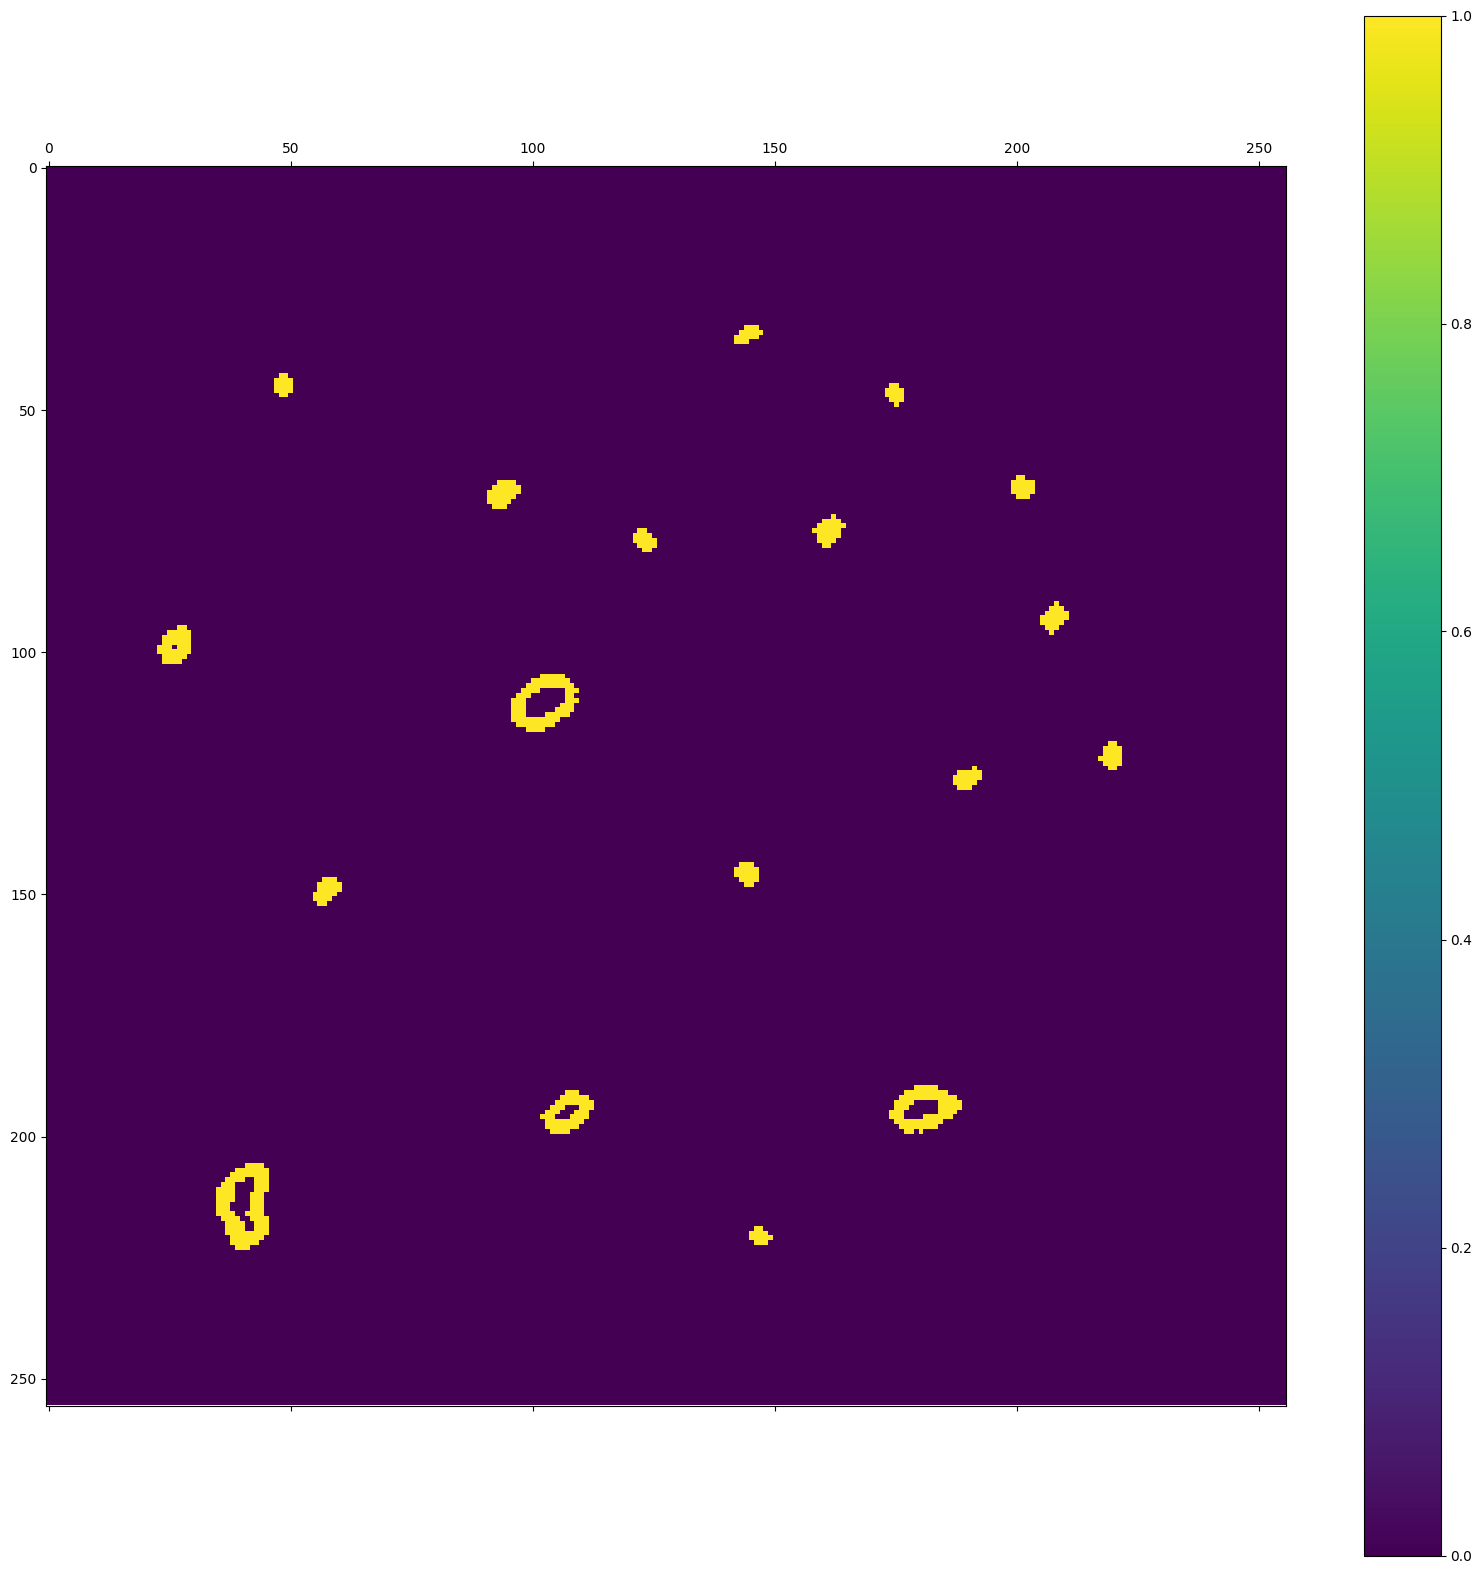

In [132]:
# copies env resv and convolved it with a kernel
r = tenv.resv.copy()
kernel = np.array([[0,-0.25,0],[-0.25,1,-0.25],[0,-0.25,0]], dtype=np.float32)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
# adds colorbar 
fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)>0), cmap="hot")


/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/3711006157.py:3: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)<0), cmap="hot")


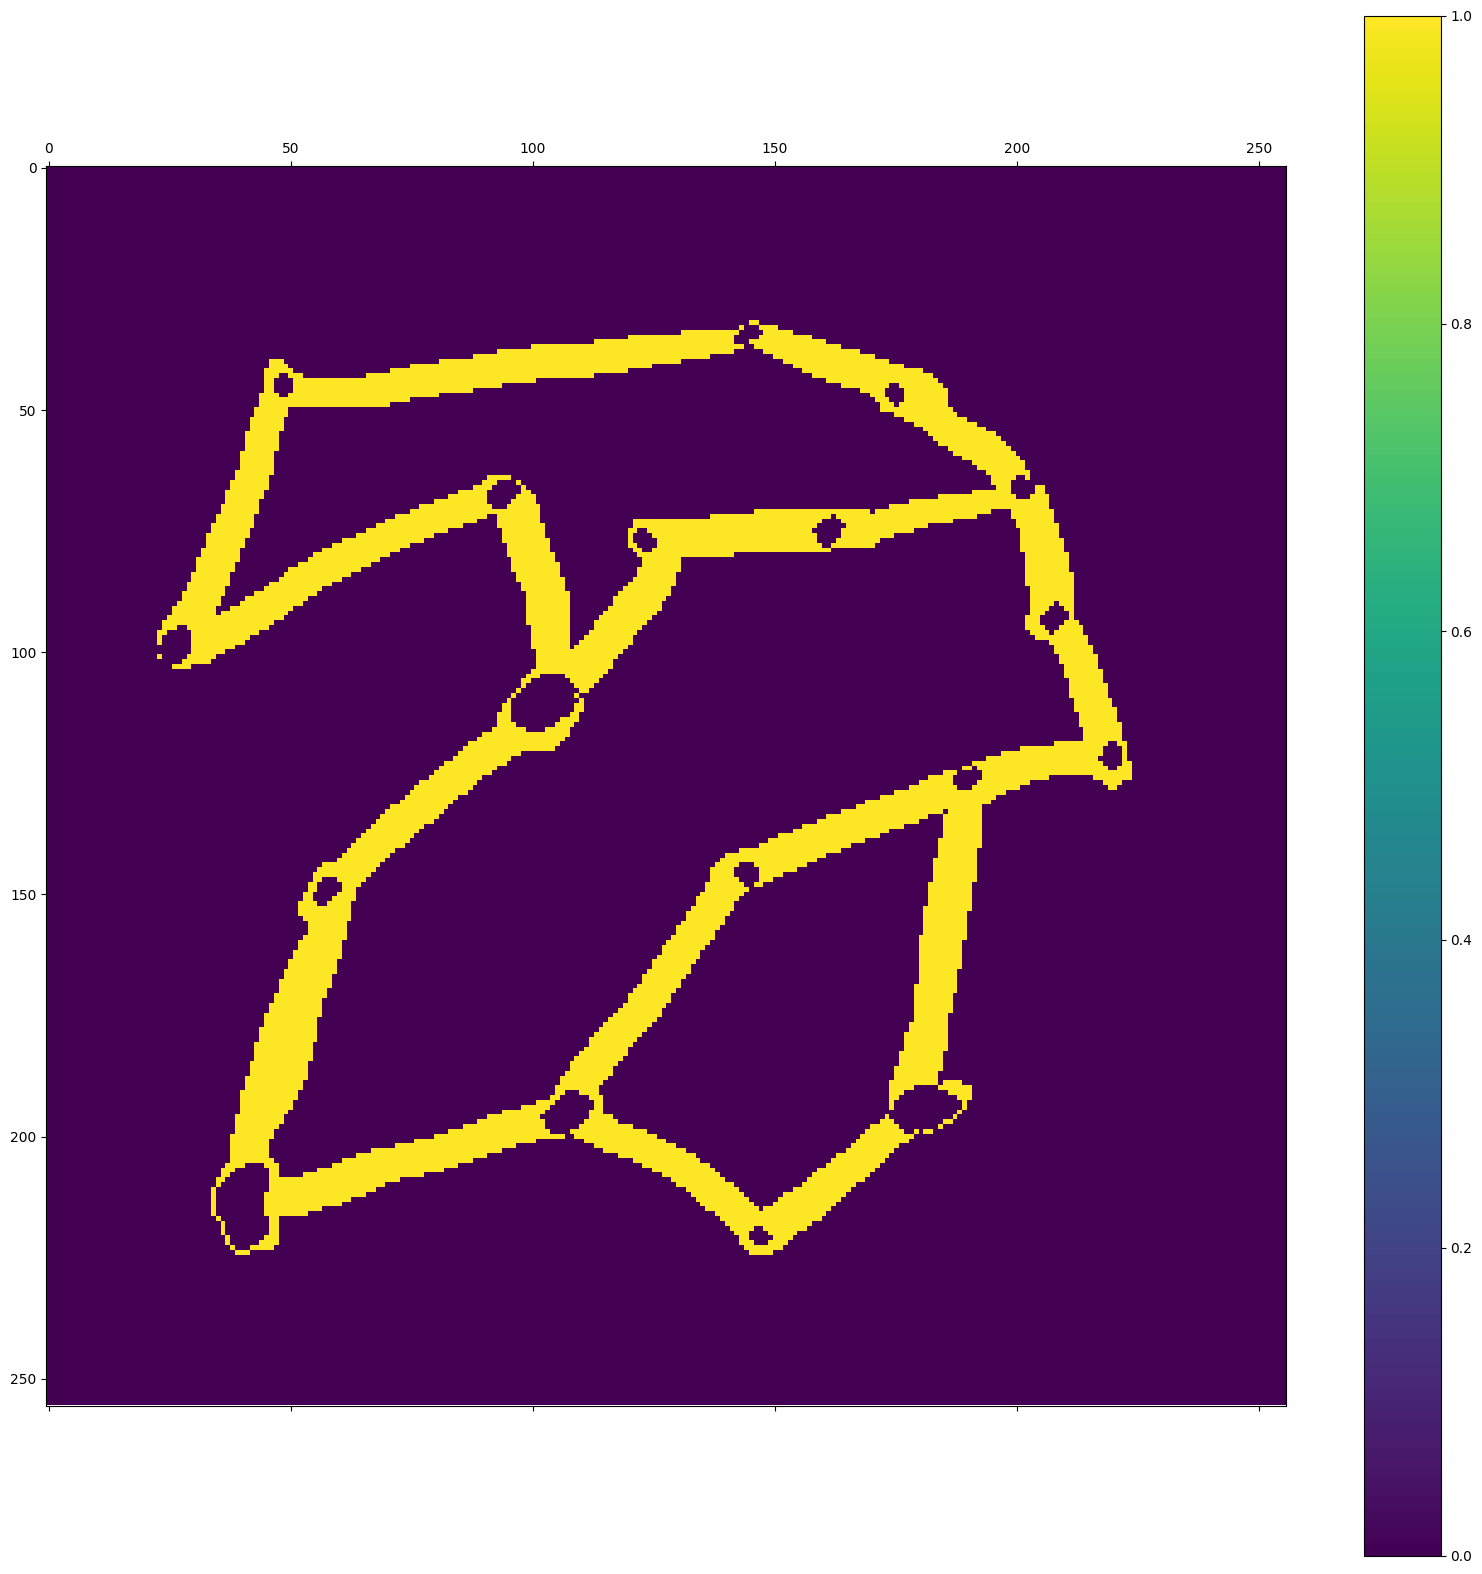

In [133]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)<0), cmap="hot")

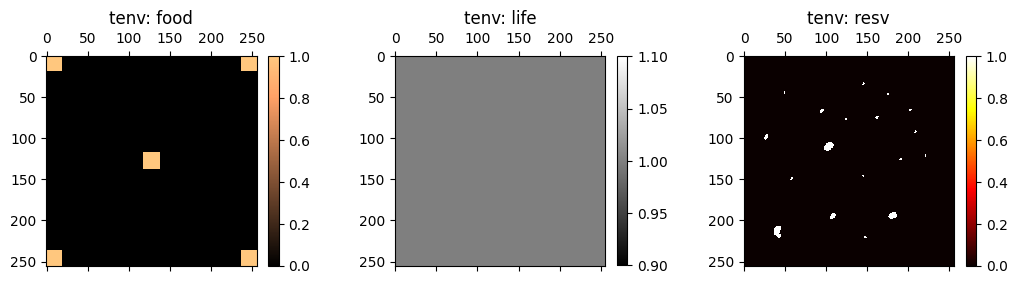

In [54]:
tenv.food = np.zeros_like(tenv.life)
tenv.life = np.ones_like(tenv.life)
# places blocks of food the size of sz in the corners and middle of a the food grid
sz=20
tenv.food[:sz,:sz] = 1
tenv.food[-sz:,-sz:] = 1
tenv.food[-sz:,:sz] = 1
tenv.food[:sz,-sz:] = 1
tenv.food[tenv.food.shape[0]//2-sz//2:tenv.food.shape[0]//2+sz//2,tenv.food.shape[1]//2-sz//2:tenv.food.shape[1]//2+sz//2] = 1


tenv.display()